In [1]:
from automatic_pitch import model, movement, plotting
from automatic_pitch.utils import get_color

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.stats import pearsonr

from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TODO: Raise error if end < start
start = '2019-07-01'
end = '2019-09-01'
data = model.get_pitches(start, end)

This is a large query, it may take a moment to complete
Completed sub-query from 2019-07-01 to 2019-07-06
Completed sub-query from 2019-07-07 to 2019-07-12
Completed sub-query from 2019-07-13 to 2019-07-18
Completed sub-query from 2019-07-19 to 2019-07-24
Completed sub-query from 2019-07-25 to 2019-07-30
Completed sub-query from 2019-07-31 to 2019-08-05
Completed sub-query from 2019-08-06 to 2019-08-11
Completed sub-query from 2019-08-12 to 2019-08-17
Completed sub-query from 2019-08-18 to 2019-08-23
Completed sub-query from 2019-08-24 to 2019-08-29
Completed sub-query from 2019-08-30 to 2019-09-01


In [3]:
# Add movement in x and z directions
v_o = np.array([data.vx0, data.vy0, data.vz0])
p_o = np.array([data.release_pos_x, data.release_pos_y, data.release_pos_z])
a = np.array([data.ax, data.ay, data.az])
dx, dz, dzg = movement.calc_movement(p_o, v_o, a)
data['movement_x'] = dx
data['movement_z'] = dz

# Remove data points that have no pitch_type
data = data.dropna(subset=['pitch_type', "release_extension", "release_spin_rate"])
#data = data.dropna()
pitch_types = list(set(data.pitch_type.values))

In [4]:
columns = list(data.columns)
columns_keep = ['pitch_type', 
                'release_speed',
                'p_throws',
                'release_pos_x',
                'release_pos_z',
                'movement_x',
                'movement_z',
                'plate_x',
                'plate_z',
                'zone',
                'vx0',
                'vy0',
                'vz0',
                'ax',
                'ay',
                'az',
                'release_spin_rate',
                'release_extension',
                'release_pos_y'
               ]

# Drop dolumns not in `columns_keep`
col_to_drop = model.remove_columns(columns, columns_keep)
data = data.drop(col_to_drop, axis=1)

In [5]:
np.where(data.isnull())

(array([], dtype=int64), array([], dtype=int64))

## Univariate Analysis

Text(0.5, 148.04655737704917, 'movement (ft)')

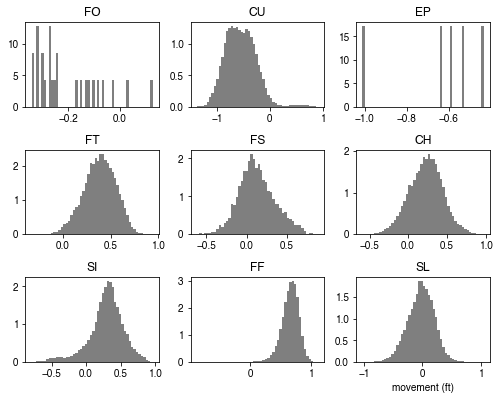

In [6]:
var = "movement_z"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

Fortunately, we have enough data and with the exception of ephus and forkballs, the distributions are normal.

Here, we should mainly see the vertical movement as a result of magnus force.  A four-seam fastball is thrown with backspin which should result in an upward magnus force.  It makes sense then that the majority of four-seam fastballs have a positive z movement.  We see this similarly for changeups, though with lower movement due to a different grip. Curve balls are thrown with top-spin so we largely see negative z movement.  Sliders mainly have a horizontal spin, so we see that the z movement is centered around 0.  We see this slightly with a splitter as well.

One thing I don't quite understand right now is the z movement of the sinker.

Text(0.5, 41.99999999999994, 'movement (ft)')

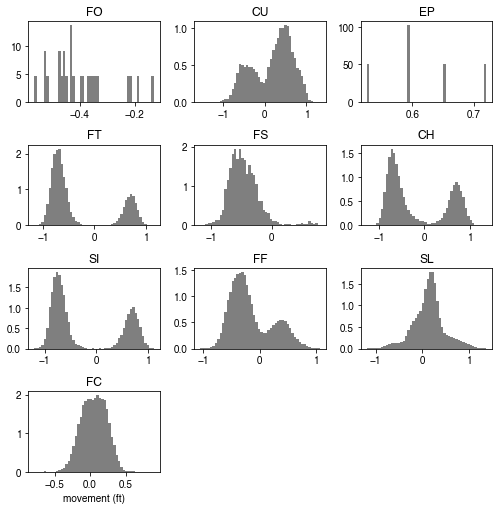

In [7]:
var = "movement_x"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

The bimodal distributions are due to the handedness of the pitchers.  Let's look at the absolute value of the x movements.

Text(0.5, 41.99999999999994, 'movement (ft)')

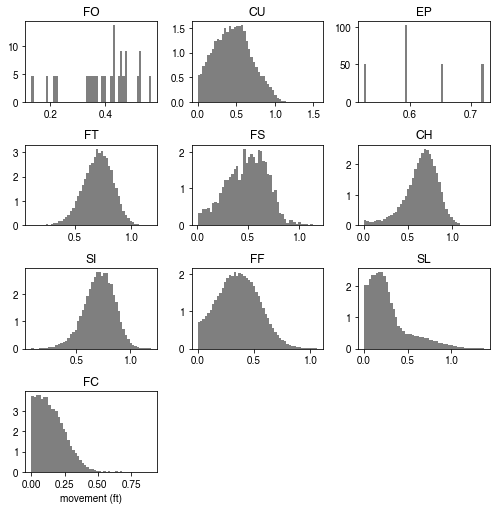

In [8]:
var = "movement_x"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(abs(data[var][(data["pitch_type"] == pitch_types[i-1])]), alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

For the most part, these distributions seem normal.  The cutters

Text(0.5, 41.99999999999994, 'movement (ft)')

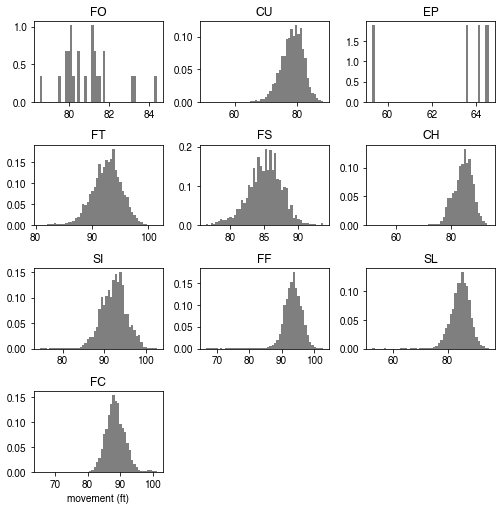

In [9]:
var = "release_speed"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

In [16]:
The distributions are normal

SyntaxError: invalid syntax (<ipython-input-16-60349946d0f4>, line 1)

Text(0.5, 41.99999999999994, 'movement (ft)')

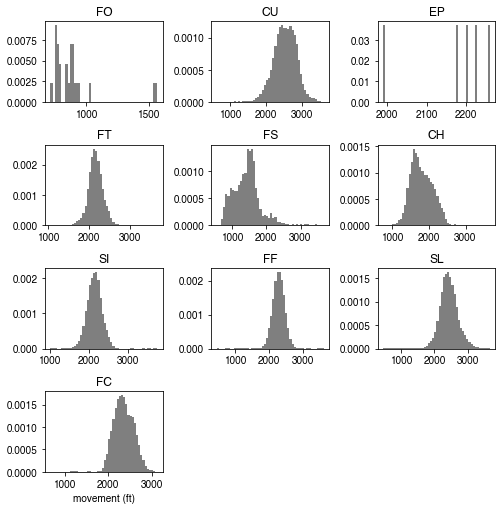

In [10]:
var = "release_spin_rate"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

Text(0.5, 41.99999999999994, 'movement (ft)')

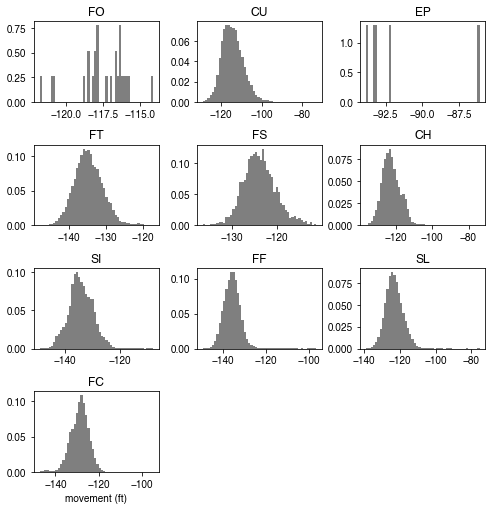

In [34]:
var = "vy0"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

Text(0.5, 41.99999999999994, 'movement (ft)')

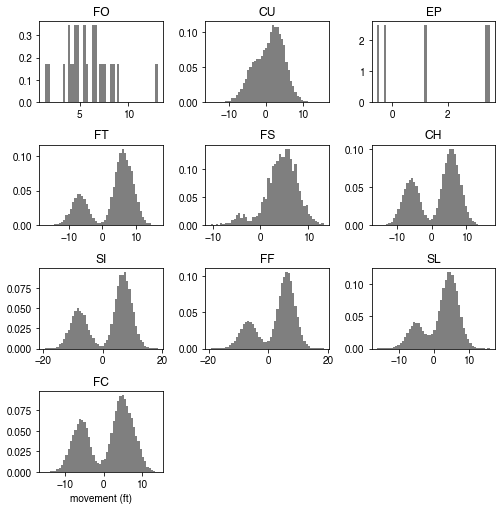

In [36]:
var = "vx0"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

Text(0.5, 41.99999999999994, 'movement (ft)')

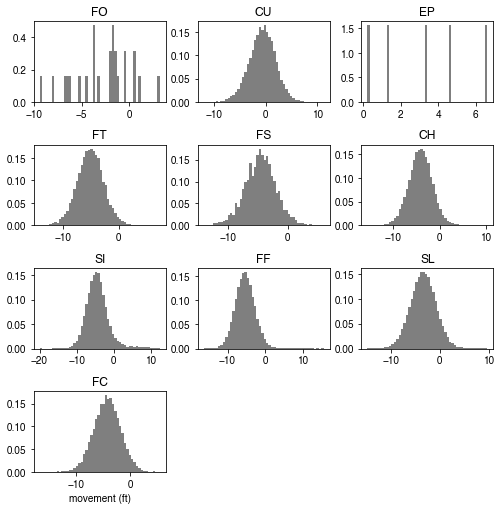

In [37]:
var = "vz0"
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data[var][(data["pitch_type"] == pitch_types[i-1])], alpha=0.5, bins=50, color='k', density=True)
plt.tight_layout()
plt.xlabel("movement (ft)")

Checking the starting positions as a sanity check to make sure there aren't any faulty measurements.  All of these are normal distributions, so it seems like we don't need to discard any data.

Text(0.5, 41.99999999999994, 'movement (ft)')

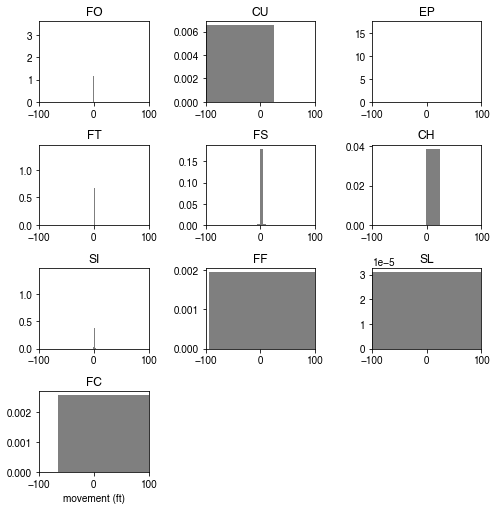

In [46]:
# This might be a good way to detect outliers
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(4, 3, i)
    ax.set_title(pitch_types[i-1])
    ax.hist(data["movement_z"][(data["pitch_type"] == pitch_types[i-1])]/np.abs(data["movement_x"][(data["pitch_type"] == pitch_types[i-1])]), alpha=0.5, bins=50, color='k', density=True)
    ax.set_xlim((-100, 100))
plt.tight_layout()
plt.xlabel("movement (ft)")


Some of these pitches have a very high ratio, part of which is due to a very low movement in the x-direction.  Might need to investigate this more.

## Bivariate Analysis

Text(0.5, 69.00000000000009, 'movement (ft)')

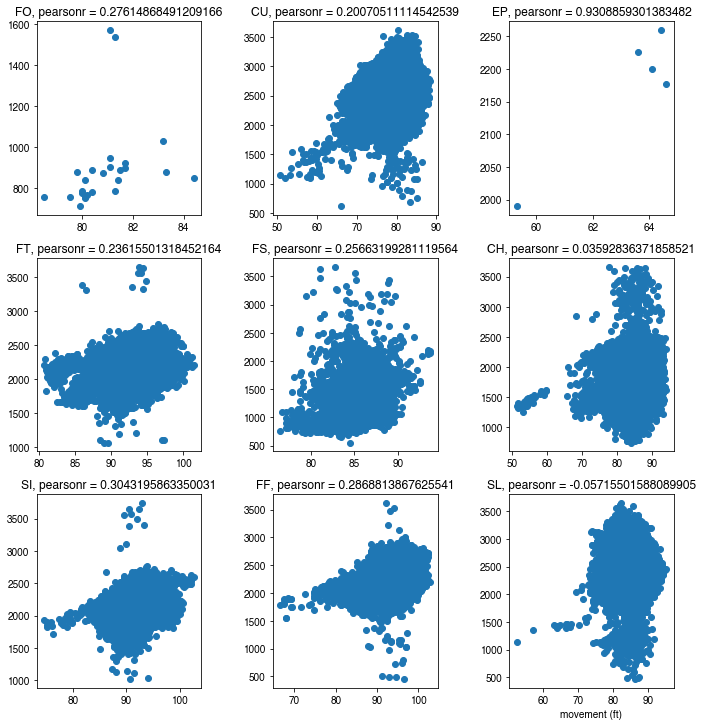

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    corr, _ = pearsonr(data["release_speed"][data["pitch_type"] == pitch_types[i-1]], data["release_spin_rate"][data["pitch_type"] == pitch_types[i-1]])
    ax.set_title(f"{pitch_types[i-1]}, pearsonr = {corr}")
    ax.scatter(data["release_speed"][data["pitch_type"] == pitch_types[i-1]], data["release_spin_rate"][data["pitch_type"] == pitch_types[i-1]])
plt.tight_layout()
plt.xlabel("movement (ft)")

Overall, the correlation between spin rate and speed is pretty low.  

Text(0.5, 69.00000000000009, 'movement (ft)')

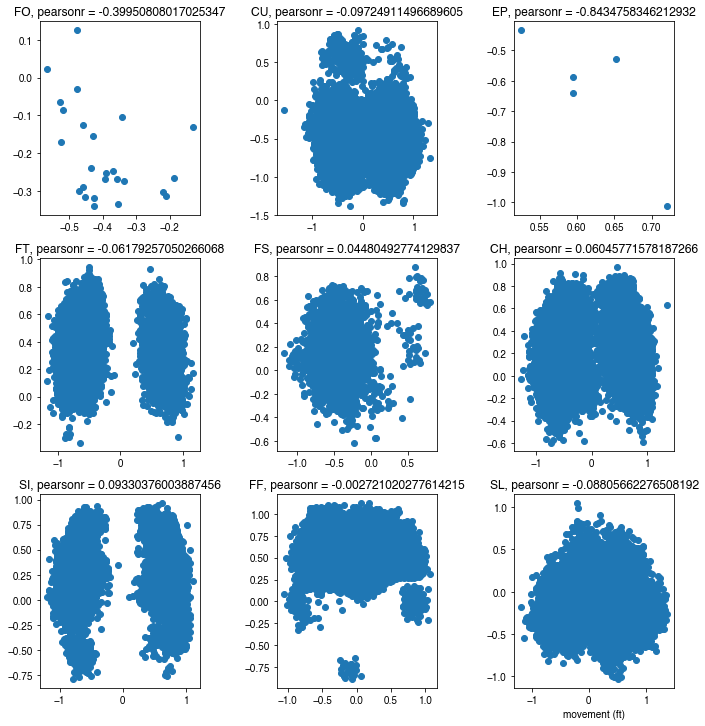

In [13]:
x_var = "movement_x"
y_var = "movement_z"
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    corr, _ = pearsonr(data[x_var][data["pitch_type"] == pitch_types[i-1]], data[y_var][data["pitch_type"] == pitch_types[i-1]])
    ax.set_title(f"{pitch_types[i-1]}, pearsonr = {corr}")
    ax.scatter(data[x_var][data["pitch_type"] == pitch_types[i-1]], data[y_var][data["pitch_type"] == pitch_types[i-1]])
plt.tight_layout()
plt.xlabel("movement (ft)")

Not much of a correlation between movement in x and z direction.  However we do see two distributions likely due to right-handed and left-handed pitchers.  Will need to figure out how to deal with this, maybe, taking the absolute value.

Text(0.5, 69.00000000000009, 'movement (ft)')

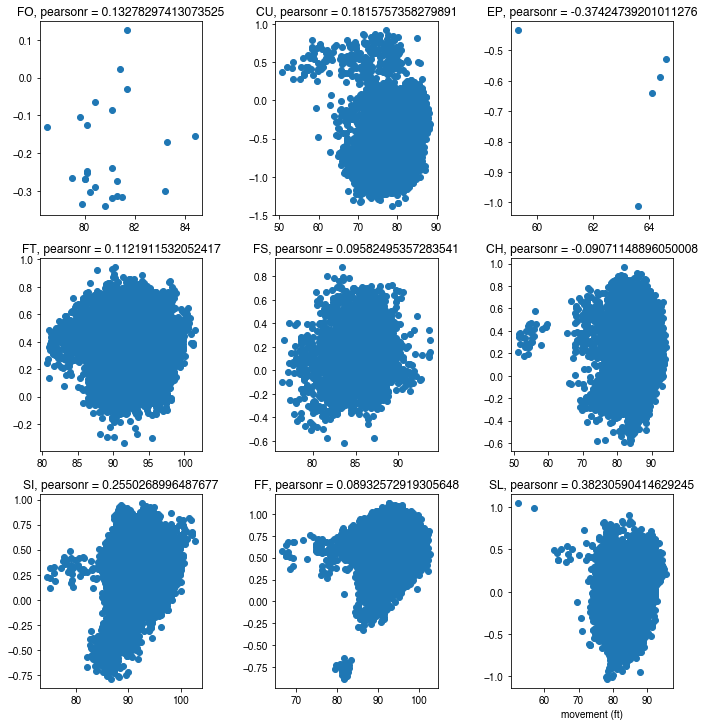

In [14]:
x_var = "release_speed"
y_var = "movement_z"
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    corr, _ = pearsonr(data[x_var][data["pitch_type"] == pitch_types[i-1]], data[y_var][data["pitch_type"] == pitch_types[i-1]])
    ax.set_title(f"{pitch_types[i-1]}, pearsonr = {corr}")
    ax.scatter(data[x_var][data["pitch_type"] == pitch_types[i-1]], data[y_var][data["pitch_type"] == pitch_types[i-1]])
plt.tight_layout()
plt.xlabel("movement (ft)")

There is a bit more of a correlation between release_speed and movement in z direction, particularly for cutters, sliders, curves, and knuckle-curves.

Text(0.5, 69.00000000000009, 'movement (ft)')

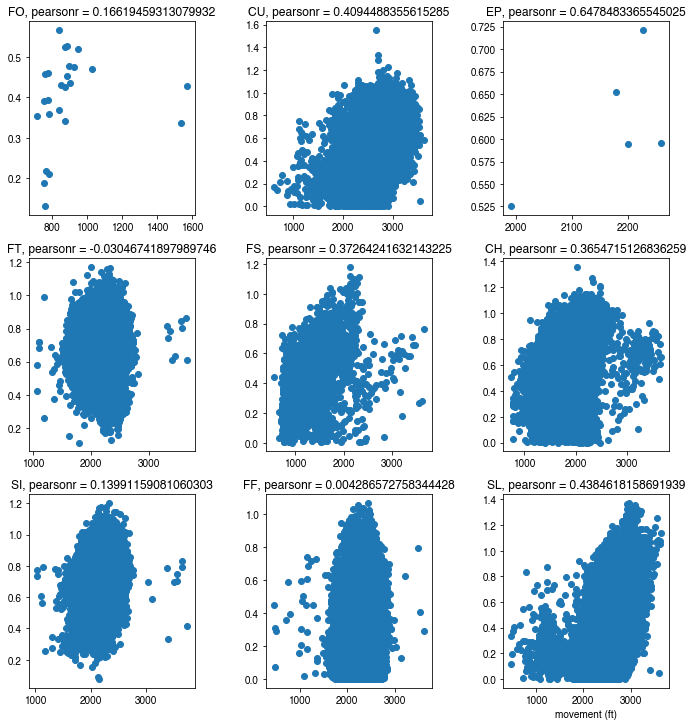

In [15]:
x_var = "release_spin_rate"
y_var = "movement_x"
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    corr, _ = pearsonr(data[x_var][data["pitch_type"] == pitch_types[i-1]], np.abs(data[y_var][data["pitch_type"] == pitch_types[i-1]]))
    ax.set_title(f"{pitch_types[i-1]}, pearsonr = {corr}")
    ax.scatter(data[x_var][data["pitch_type"] == pitch_types[i-1]], np.abs(data[y_var][data["pitch_type"] == pitch_types[i-1]]))
plt.tight_layout()
plt.xlabel("movement (ft)")

## Conclusions
- The majority of this data is normal, there are some skewed distributions
- We see 2 distributions of data related to the x direction, we can probably handle this by taking the absolute value.
- For now, I'm going to not consider forkballs and ephus due to lack of data
- There are some outliers, not sure yet how to deal with them.